In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys
import graphviz 
# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')
    
import file_utils
import utils
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from pathlib import Path
from sklearn.model_selection import GridSearchCV
from time import time
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)
print("sklearn version: ", sklearn.__version__)

Seaborn version:  0.9.0
sklearn version:  0.20.2


In [2]:
summary_team_file = '../Data/sr_summaries_kaggle_id_no_opp_2018.csv'
team_meta_data_file = '../Data/D1_teams.csv'
tournament_data_file = '../Data/tournament_results_2018.csv'
rankings_data_file = '../data/massey_seasons_with_id.csv'

feature_dictionary = utils.Feature_Dictionary()

In [3]:
def get_missed_predictions(tourney_comp_ratings, prediction_probabilities, X, y, y_pred):
    
    pred_probs = pd.Series(prediction_probabilities[:,1], index=X.index)
    predictions = pd.Series(y_pred, index=y.index)
    test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X.index)].copy()
    test_games['predicted_result'] = predictions
    test_games['pred_win_prob'] = pred_probs
    missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)
   

    return missed_predictions

In [4]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [5]:
# earliest season data starts in 2000 corresponding to tournament season date of 2001
start_tournament = 2003
stop_tournament = 2017

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [6]:
summary_data = file_utils.read_summary_team_data(summary_team_file)
teams = file_utils.read_team_meta_data(team_meta_data_file)
summary_data.head()

,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


In [7]:
tourney_data = file_utils.read_tournament_results(tournament_data_file,start_tournament)
game_data = utils.compute_game_data(tourney_data, teams)
computer_rankings = pd.read_csv(Path(rankings_data_file))
computer_rankings = computer_rankings[computer_rankings['season'] >= start_tournament]

tourney_data = utils.recode_tourney_data(tourney_data)
tourney_data = file_utils.merge_tourney_summary_data(tourney_data, summary_data)
tourney_data = file_utils.join_tourney_team_data(tourney_data, teams)
tourney_comp_ratings = file_utils.merge_tourney_ranking_data(tourney_data, computer_rankings)
tourney_comp_ratings = utils.implement_top_conference_feature(game_data, tourney_comp_ratings)
tourney_comp_ratings = utils.implement_seed_threshold_feature(tourney_comp_ratings)
tourney_comp_ratings = utils.compute_delta_features(tourney_comp_ratings)

tourney_comp_ratings.dropna(inplace=True)
tourney_comp_ratings[tourney_comp_ratings.isnull().any(axis=1)]


,season_t,round,game_date,seed_t,team_t,team_id_t,win_pts,seed_o,team_o,team_id_o,lose_pts,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor


In [8]:
numeric_features = ['delta_margin_victory_avg', 'delta_fg_pct', 'delta_off_rebs_avg',
                            'delta_def_rebs_avg', 'delta_ft_pct',
                            'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating',
                            'delta_ft_att_avg',
                            'delta_seed', 'delta_srs', 'delta_sos',
                            'delta_sag', 'delta_wlk', 'delta_wol',
                            'delta_rth', 'delta_col', 'delta_pom',
                            'delta_dol', 'delta_mor']



for item in numeric_features:
    tourney_comp_ratings[item] = tourney_comp_ratings[item].astype(float)


In [9]:
feature_columns = numeric_features  + ['season_t', 'top_conf_t', 'top_conf_o']
feature_data = tourney_comp_ratings[feature_columns].copy()
feature_data.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
0,2.0,0.007,1.0,1.0,0.063,0.0,-0.061,2.364814,2.0,-1.0,3.05,0.86,-8.0,12.0,8.0,2.0,12.0,5.0,-4.0,-39.0,2003,0,0
1,4.0,0.017,-1.0,-1.0,-0.002,-1.0,-0.009,7.042104,-5.0,-13.0,20.19,14.63,-131.0,-91.0,-104.0,-133.0,-73.0,-128.0,-85.0,-162.0,2003,1,0
2,5.0,-0.012,2.0,3.0,0.092,1.0,0.159,4.598761,6.0,-8.0,4.28,-1.38,-34.0,-38.0,-36.0,-33.0,-36.0,-33.0,-39.0,-24.0,2003,0,0
3,-6.0,0.022,1.0,-1.0,-0.026,3.0,-0.120,-4.525801,0.0,3.0,-1.93,4.63,23.0,31.0,13.0,12.0,17.0,27.0,21.0,6.0,2003,1,0
4,0.0,-0.029,3.0,-2.0,0.027,1.0,-0.069,-0.666215,1.0,-2.0,-0.11,0.25,-7.0,-7.0,2.0,-6.0,-5.0,-8.0,2.0,-9.0,2003,0,0


In [11]:
X = feature_data[feature_data['season_t']<= stop_tournament]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']<= stop_tournament]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_mor',
 'top_conf_t',
 'top_conf_o']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
X_train = X_train.copy()
X_test = X_test.copy()




In [14]:
scaler=StandardScaler(copy=True, with_mean=True, with_std=True)

scaler.fit(X_train[numeric_features])
X_train[numeric_features] = scaler.transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

#### AdaBoost

In [15]:
number_estimators = 501

ada= AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME.R", n_estimators=number_estimators,
                       learning_rate = 1)

ada.fit(X_train, y_train)
ada_training_score = ada.score(X_train, y_train)
print("Ada Training Model Score= ", ada_training_score)
y_pred_ada = ada.predict(X_test)
ada_prediction_probabilities = ada.predict_proba(X_test)

print("AdaBoost model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred_ada))
print("Ada Log loss= ",log_loss(y_test, ada_prediction_probabilities))

ada_missed_predictions = get_missed_predictions(tourney_comp_ratings, ada_prediction_probabilities, 
                                                         X_test, y_test, y_pred_ada)

print("Ada Missed predictions= ", ada_missed_predictions.shape[0])

Ada Training Model Score=  0.9961636828644501
AdaBoost model accuracy is 0.78
Ada Log loss=  0.6815166985813035
Ada Missed predictions=  44


#### Logistic Regression

In [17]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
logreg_training_score = logreg.score(X_train, y_train)
print("Logistic Regression Training Model Score= ", logreg_training_score)

y_pred_logreg = logreg.predict(X_test)
logreg_prediction_probabilities = logreg.predict_proba(X_test)

print("Logistic Regression model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Log loss= ",log_loss(y_test, logreg_prediction_probabilities))

logreg_missed_predictions = get_missed_predictions(tourney_comp_ratings, logreg_prediction_probabilities, 
                                                         X_test, y_test, y_pred_logreg)

print("Logistic Regression Missed predictions= ", logreg_missed_predictions.shape[0])

Logistic Regression Training Model Score=  0.8439897698209718
Logistic Regression model accuracy is 0.80
Logistic Regression Log loss=  0.4660298675307945
Logistic Regression Missed predictions=  40


#### Random Forest

In [18]:
rf_classifier = RandomForestClassifier(2000, max_features='sqrt', min_samples_split=2, 
                                       min_samples_leaf=2, max_depth=10, random_state=0)

rf_classifier.fit(X_train, y_train)
rf_training_score = rf_classifier.score(X_train, y_train)
print("RF Training Model Score= ", rf_training_score)
y_pred_rf = rf_classifier.predict(X_test)
rf_prediction_probabilities = rf_classifier.predict_proba(X_test)

print("RF model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred_rf))
print("RF Log loss= ",log_loss(y_test, rf_prediction_probabilities))

rf_missed_predictions = get_missed_predictions(tourney_comp_ratings, rf_prediction_probabilities, 
                                                         X_test, y_test, y_pred_rf)

print("RF Missed predictions= ", rf_missed_predictions.shape[0])

RF Training Model Score=  0.9884910485933504
RF model accuracy is 0.65
RF Log loss=  0.5995271464957872
RF Missed predictions=  69


#### Voting Classifier

In [19]:
vc = VotingClassifier(estimators=[('lr',logreg),('ada', ada)], voting='soft')
vc.fit(X_train, y_train)
y_pred_vc = vc.predict(X_test)

vc_prediction_probabilities = vc.predict_proba(X_test)

print("VC model accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred_vc))
print("VC Log loss= ",log_loss(y_test, vc_prediction_probabilities))

vc_missed_predictions = get_missed_predictions(tourney_comp_ratings, vc_prediction_probabilities, 
                                                         X_test, y_test, y_pred_vc)

print("VC Missed predictions= ", vc_missed_predictions.shape[0])

VC model accuracy is 0.80
VC Log loss=  0.5226015576315327
VC Missed predictions=  40


### 2018 Tournament Predictions

In [20]:
test_year = 2018
# scale the feature data corresponding to the 2018 tournament
feature_copy = feature_data[feature_data['season_t'] == test_year].copy()
feature_copy[numeric_features] = scaler.transform(feature_copy[numeric_features])
feature_copy.head()

,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_mor,season_t,top_conf_t,top_conf_o
981,0.370585,-0.915614,0.413233,-1.509369,0.595567,-1.197856,0.952731,-0.650609,-1.369671,-0.064122,0.592550,0.637418,-0.991321,-1.180552,-1.411298,-1.168129,-1.328438,-1.243847,-1.365329,-0.599634,2018,0,0
982,-0.117838,0.305819,0.015757,1.183684,-0.627935,1.203999,-0.877062,0.161184,-0.534193,-0.064122,0.340830,0.657734,-0.287731,-0.291368,0.195876,-0.277366,-0.010788,-0.357100,0.051601,-0.134591,2018,1,0
983,-0.769069,-0.696382,-0.381719,-0.355203,0.776083,-0.797547,-0.660945,0.730839,2.250733,-0.064122,0.561984,1.024889,-0.819013,-0.930956,-0.297415,-0.290863,-0.524993,-0.924037,-0.318033,-0.791122,2018,0,0
984,0.859009,1.464614,-0.779195,0.029518,-0.046271,-0.797547,0.073854,2.185083,0.858270,-0.064122,0.186203,-0.461143,-0.072346,-0.166570,-0.026901,-0.115410,-0.107201,-0.182658,0.051601,0.056897,2018,0,0
985,-1.257492,-0.508470,0.413233,0.029518,-2.152299,1.203999,-1.518210,-0.614491,1.136763,1.946981,-2.125119,-1.832529,2.627143,2.532181,1.914437,2.300445,2.174584,2.608413,1.822763,2.053846,2018,0,1


array([[28,  5],
       [ 5, 29]], dtype=int64)

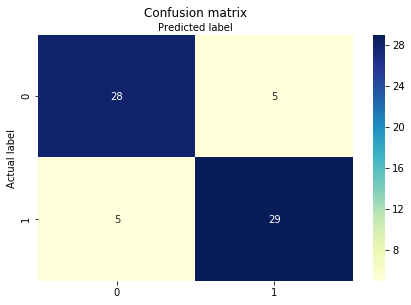

In [21]:
X_season = feature_copy[feature_list]

y_season = tourney_comp_ratings[tourney_comp_ratings['season_t']== test_year]['game_result']
X_season.shape

y_pred_season = vc.predict(X_season)
utils.display_confusion_matrix(y_season,y_pred_season)


In [22]:
prediction_probabilities =  vc.predict_proba(X_season)
print("Accuracy:",metrics.accuracy_score(y_season, y_pred_season))
print("Precision:", metrics.precision_score(y_season,y_pred_season))
print("Recall:",metrics.recall_score(y_season, y_pred_season))
print("Log loss= ",log_loss(y_season, prediction_probabilities))

Accuracy: 0.8507462686567164
Precision: 0.8529411764705882
Recall: 0.8529411764705882
Log loss=  0.4972651805884589
